In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.utils import resample
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#reading from imported csv's

In [ ]:
df_new  =   pd.read_csv('/content/df_new_afterOutliers.csv',encoding = 'ISO-8859-1')
df_new

,word_count,statement_length,num_words,avg_word_length,vocabulary_size,statement,status
0,2.397895,4.094345,2.397895,1.609438,2.397895,caitlinaudrey aww suck go sydney one,0
1,5.556828,7.211557,5.556828,1.609438,5.176150,feel like kill still one listen convinc suffer...,4
2,4.615121,6.464588,4.615121,1.791759,4.382027,hellom hellodl hello know saydl okay someth mi...,2
3,3.610918,5.010635,3.610918,1.386294,3.295837,feel like believ realli go trial run see relie...,1
4,4.521789,6.249975,4.521789,1.791759,4.174387,depress realism exist matrix peopl came fine c...,1
...,...,...,...,...,...,...,...
41359,5.669881,7.329750,5.669881,1.609438,5.170484,feel need take reveng isol dont care sound edg...,6
41360,5.273000,6.836259,5.273000,1.609438,4.718499,went busi store today hello everyon hope your ...,6
41361,3.784190,5.375278,3.784190,1.609438,3.610918,even worth like worth live life full fear avoi...,6
41362,5.533389,7.230563,5.533389,1.609438,5.105945,cope gonna realli weird random want share beca...,6


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['statement'].astype(str), df_new['status'], test_size=0.2, random_state=42)

In [ ]:
train_embeddings = pd.read_csv('/content/train_embeddings.csv',encoding = 'ISO-8859-1')
test_embeddings = pd.read_csv('/content/test_embeddings.csv',encoding = 'ISO-8859-1')

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
#!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# Fit and transform the TF-IDF vectors
vectorizer.fit(X_train)  # Fit to training data
X_train_tfidf = vectorizer.transform(X_train)  # Transform training data
X_test_tfidf = vectorizer.transform(X_test)    # Transform testing data

# Concatenate BERT embeddings and TF-IDF features
X_train_combined = np.hstack((train_embeddings, X_train_tfidf.toarray()))
X_test_combined = np.hstack((test_embeddings, X_test_tfidf.toarray()))

# 1. Normalize/Scale the Combined Features
#scaler = StandardScaler()

# Fit on the training data and transform both training and test data
#X_train_combined_scaled = scaler.fit_transform(X_train_combined)
#X_test_combined_scaled = scaler.transform(X_test_combined)



In [ ]:
X_train_tfidf.shape

(33091, 26894)

In [ ]:
df_new.shape

(41364, 7)

In [ ]:
test_embeddings.shape

(8273, 768)

In [ ]:
train_embeddings.shape

(33091, 768)

#Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the Logistic Regression model without scaling
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_combined, y_train)

# Make predictions
y_pred = logreg.predict(X_test_combined)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1091
           1       0.73      0.62      0.67      1221
           2       0.73      0.74      0.73      1194
           3       0.94      0.94      0.94      1227
           4       0.95      0.97      0.96      1210
           5       0.90      0.96      0.93      1156
           6       0.96      1.00      0.98      1174

    accuracy                           0.87      8273
   macro avg       0.87      0.88      0.87      8273
weighted avg       0.87      0.87      0.87      8273

Confusion Matrix:
 [[ 976   18   26    9    7   44   11]
 [  40  762  290   40   32   40   17]
 [  52  230  882    6   11   11    2]
 [   2   15    6 1159    9   28    8]
 [   6    9    2    1 1178    5    9]
 [   2   14    5   24    2 1106    3]
 [   0    0    0    0    0    0 1174]]


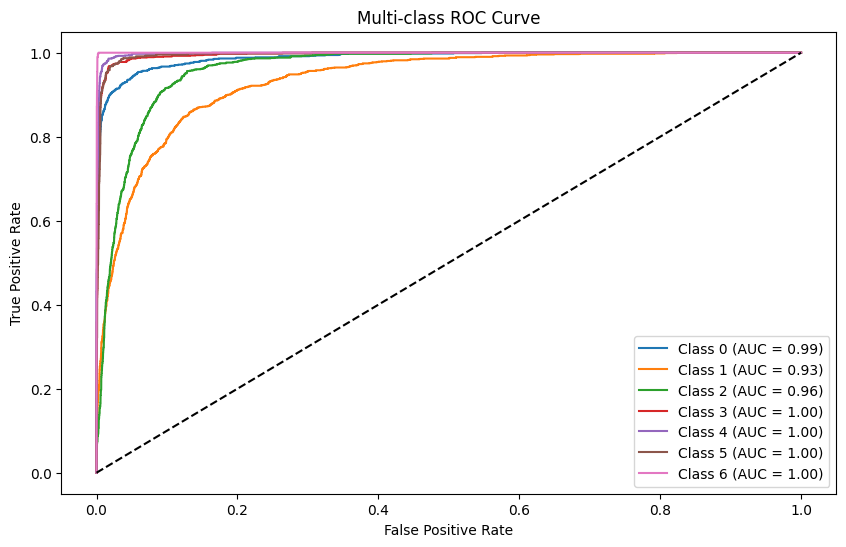

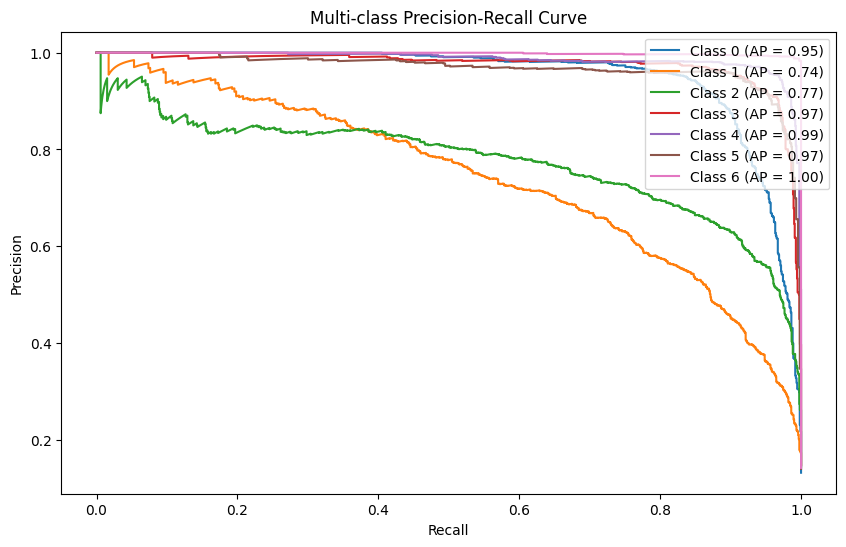

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class classification
n_classes = len(np.unique(y_test))  # Number of classes
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob = logreg.predict_proba(X_test_combined)  # Get probability estimates

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on test and train sets
y_test_pred = logreg.predict(X_test_combined)
y_train_pred = logreg.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate Precision (macro)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')

# Calculate Recall (macro)
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')

# Calculate F1 Score (macro)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

# Display the results
print("Model: Logistic Regression")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision_macro:.4f}")
print(f"Train Precision (macro): {train_precision_macro:.4f}")
print(f"Test Recall (macro): {test_recall_macro:.4f}")
print(f"Train Recall (macro): {train_recall_macro:.4f}")
print(f"Test F1 Score (macro): {test_f1_macro:.4f}")
print(f"Train F1 Score (macro): {train_f1_macro:.4f}")


Model: Logistic Regression
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.8748
Train Accuracy: 0.9168
Test Precision (macro): 0.8718
Train Precision (macro): 0.9156
Test Recall (macro): 0.8760
Train Recall (macro): 0.9177
Test F1 Score (macro): 0.8731
Train F1 Score (macro): 0.9159


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Make predictions on test and train sets
y_test_pred = logreg.predict(X_test_combined)
y_train_pred = logreg.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the results for each class
print("Model: Logistic Regression")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score, and Accuracy
print("\nTest Metrics for each class:")
for i, class_label in enumerate(test_classification_report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")
        print(f"  Accuracy: {class_wise_accuracy[i]:.4f}")

print("\nTrain Metrics for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


Confusion Matrix:
 [[ 976   18   26    9    7   44   11]
 [  40  762  290   40   32   40   17]
 [  52  230  882    6   11   11    2]
 [   2   15    6 1159    9   28    8]
 [   6    9    2    1 1178    5    9]
 [   2   14    5   24    2 1106    3]
 [   0    0    0    0    0    0 1174]]
Model: Logistic Regression
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.8748
Train Accuracy: 0.9168

Test Metrics for each class:
Class 0:
  Precision: 0.9054
  Recall: 0.8946
  F1 Score: 0.9000
  Accuracy: 0.8946
Class 1:
  Precision: 0.7271
  Recall: 0.6241
  F1 Score: 0.6717
  Accuracy: 0.6241
Class 2:
  Precision: 0.7283
  Recall: 0.7387
  F1 Score: 0.7335
  Accuracy: 0.7387
Class 3:
  Precision: 0.9354
  Recall: 0.9446
  F1 Score: 0.9400
  Accuracy: 0.9446
Class 4:
  Precision: 0.9508
  Recall: 0.9736
  F1 Score: 0.9620
  Accuracy: 0.9736
Class 5:
  Precision: 0.8963
  Recall: 0.9567
  F1 Score: 0.9255
  Accuracy: 0.9567
Class 6:
  Precision: 0.9592
  Recall: 1.0000
  F1 Score: 0.

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
y_test_pred = rf_model.predict(X_test_combined)
y_train_pred = rf_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate Precision (macro)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')

# Calculate Recall (macro)
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')

# Calculate F1 Score (macro)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

# Display the results
print("Model: Random Forest")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision_macro:.4f}")
print(f"Train Precision (macro): {train_precision_macro:.4f}")
print(f"Test Recall (macro): {test_recall_macro:.4f}")
print(f"Train Recall (macro): {train_recall_macro:.4f}")
print(f"Test F1 Score (macro): {test_f1_macro:.4f}")
print(f"Train F1 Score (macro): {train_f1_macro:.4f}")

# Classification Report for both Test and Train sets
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
print("\nClassification Report (Train Set):\n", classification_report(y_train, y_train_pred))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
y_test_pred = rf_model.predict(X_test_combined)
y_train_pred = rf_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Display the results for each class
print("Model: Random Forest")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score
print("\nTest Precision, Recall, F1 Score for each class:")
for class_label in test_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")

print("\nTrain Precision, Recall, F1 Score for each class:")
for class_label in train_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


Confusion Matrix:
 [[ 944   92   21    7    6   20    1]
 [ 137  829  213   14   20    8    0]
 [  98  270  815    6    4    1    0]
 [   5    6    0 1212    3    1    0]
 [   0    5    0    2 1203    0    0]
 [   0    2    0    0    0 1154    0]
 [   0    0    0    0    0    0 1174]]
Model: Random Forest
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.8861
Train Accuracy: 0.9997

Test Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.7973
  Recall: 0.8653
  F1 Score: 0.8299
Class 1:
  Precision: 0.6885
  Recall: 0.6790
  F1 Score: 0.6837
Class 2:
  Precision: 0.7769
  Recall: 0.6826
  F1 Score: 0.7267
Class 3:
  Precision: 0.9766
  Recall: 0.9878
  F1 Score: 0.9822
Class 4:
  Precision: 0.9733
  Recall: 0.9942
  F1 Score: 0.9836
Class 5:
  Precision: 0.9747
  Recall: 0.9983
  F1 Score: 0.9863
Class 6:
  Precision: 0.9991
  Recall: 1.0000
  F1 Score: 0.9996

Train Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.9995
  Recall: 0.999

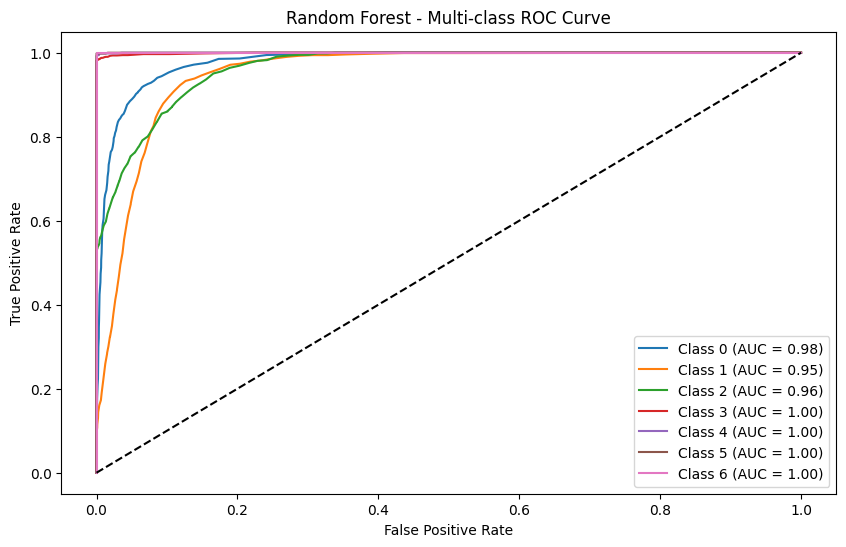

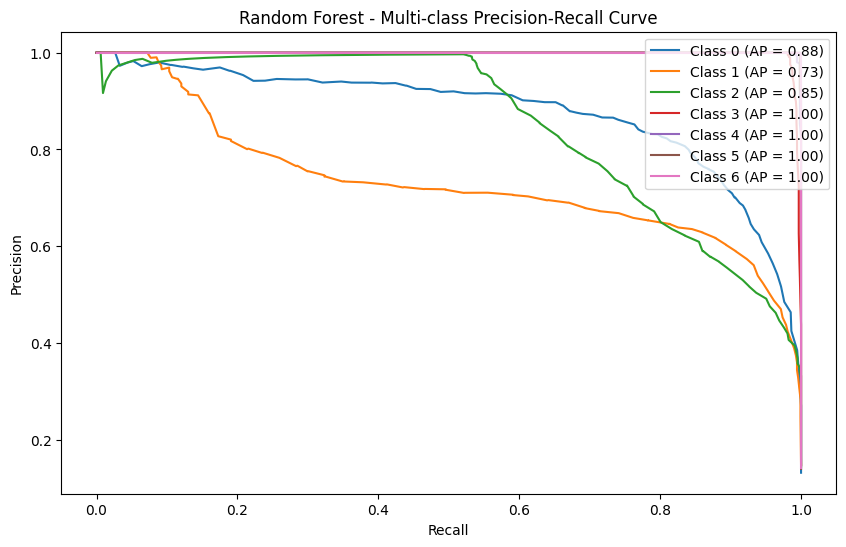

Confusion Matrix:
 [[ 953   88   17    9    5   19    0]
 [ 137  811  224   16   23   10    0]
 [ 106  272  808    5    2    1    0]
 [   5    8    1 1211    0    2    0]
 [   0    2    0    0 1208    0    0]
 [   0    0    0    2    0 1154    0]
 [   0    0    0    0    0    0 1174]]
Model: Random Forest Classifier
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.8847
Train Accuracy: 0.9997

Test Metrics for each class:
Class 0:
  Precision: 0.7935
  Recall: 0.8735
  F1 Score: 0.8316
  Accuracy: 0.8735
Class 1:
  Precision: 0.6867
  Recall: 0.6642
  F1 Score: 0.6753
  Accuracy: 0.6642
Class 2:
  Precision: 0.7695
  Recall: 0.6767
  F1 Score: 0.7201
  Accuracy: 0.6767
Class 3:
  Precision: 0.9743
  Recall: 0.9870
  F1 Score: 0.9806
  Accuracy: 0.9870
Class 4:
  Precision: 0.9758
  Recall: 0.9983
  F1 Score: 0.9869
  Accuracy: 0.9983
Class 5:
  Precision: 0.9730
  Recall: 0.9983
  F1 Score: 0.9855
  Accuracy: 0.9983
Class 6:
  Precision: 1.0000
  Recall: 1.0000
  F1 Scor

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix, accuracy_score)
from sklearn.preprocessing import label_binarize
import numpy as np

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_combined, y_train)

# Get probability estimates for ROC & Precision-Recall curves
y_pred_prob = rf.predict_proba(X_test_combined)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest - Multi-class Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Make predictions on test and train sets
y_test_pred = rf.predict(X_test_combined)
y_train_pred = rf.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the results for each class
print("Model: Random Forest Classifier")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score, and Accuracy
print("\nTest Metrics for each class:")
for i, class_label in enumerate(test_classification_report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")
        print(f"  Accuracy: {class_wise_accuracy[i]:.4f}")

print("\nTrain Metrics for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


#LightGBM

In [ ]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.7 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize and train the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
y_test_pred = lgb_model.predict(X_test_combined)
y_train_pred = lgb_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate Precision (macro)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')

# Calculate Recall (macro)
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')

# Calculate F1 Score (macro)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

# Display the results
print("Model: LightGBM")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision_macro:.4f}")
print(f"Train Precision (macro): {train_precision_macro:.4f}")
print(f"Test Recall (macro): {test_recall_macro:.4f}")
print(f"Train Recall (macro): {train_recall_macro:.4f}")
print(f"Test F1 Score (macro): {test_f1_macro:.4f}")
print(f"Train F1 Score (macro): {train_f1_macro:.4f}")

# Classification Report for both Test and Train sets
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
print("\nClassification Report (Train Set):\n", classification_report(y_train, y_train_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.482318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417549
[LightGBM] [Info] Number of data points in the train set: 33091, number of used features: 5230
[LightGBM] [Info] Start training from score -2.074708
[LightGBM] [Info] Start training from score -1.917400
[LightGBM] [Info] Start training from score -1.911660
[LightGBM] [Info] Start training from score -1.935030
[LightGBM] [Info] Start training from score -1.908802
[LightGBM] [Info] Start training from score -1.940275
[LightGBM] [Info] Start training from score -1.943224
Model: LightGBM
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.9150
Train Accuracy: 0.9886
Test Precision (macro): 0.9138
Train Precision (macro): 0.9886
Test Recall (macro): 0.9157
Train Recall (macro): 0.9889
Test F1 Score (macro): 0.9139
Train F1 Score (macro): 0.9887

Classification Report (Test Set):
    

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the LightGBM model
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
y_test_pred = lgbm_model.predict(X_test_combined)
y_train_pred = lgbm_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Display the results for each class
print("Model: LightGBM")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score
print("\nTest Precision, Recall, F1 Score for each class:")
for class_label in test_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")

print("\nTrain Precision, Recall, F1 Score for each class:")
for class_label in train_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.451637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417549
[LightGBM] [Info] Number of data points in the train set: 33091, number of used features: 5230
[LightGBM] [Info] Start training from score -2.074708
[LightGBM] [Info] Start training from score -1.917400
[LightGBM] [Info] Start training from score -1.911660
[LightGBM] [Info] Start training from score -1.935030
[LightGBM] [Info] Start training from score -1.908802
[LightGBM] [Info] Start training from score -1.940275
[LightGBM] [Info] Start training from score -1.943224
Confusion Matrix:
 [[ 986   38   20    4    5   38    0]
 [  41  842  269   26   24   14    5]
 [  46  158  985    1    2    2    0]
 [   1    3    0 1222    1    0    0]
 [   0    0    0    0 1210    0    0]
 [   0    3    0    2    0 1151    0]
 [   0    0    0    0    0    0 1174]]
Model: LightGBM
Disorder: (Specify disorder

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.648032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417549
[LightGBM] [Info] Number of data points in the train set: 33091, number of used features: 5230
[LightGBM] [Info] Start training from score -2.074708
[LightGBM] [Info] Start training from score -1.917400
[LightGBM] [Info] Start training from score -1.911660
[LightGBM] [Info] Start training from score -1.935030
[LightGBM] [Info] Start training from score -1.908802
[LightGBM] [Info] Start training from score -1.940275
[LightGBM] [Info] Start training from score -1.943224


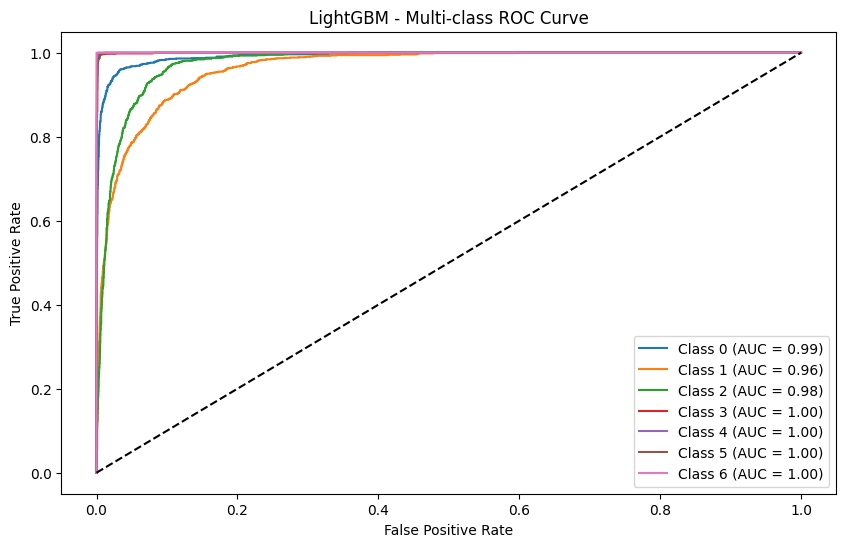

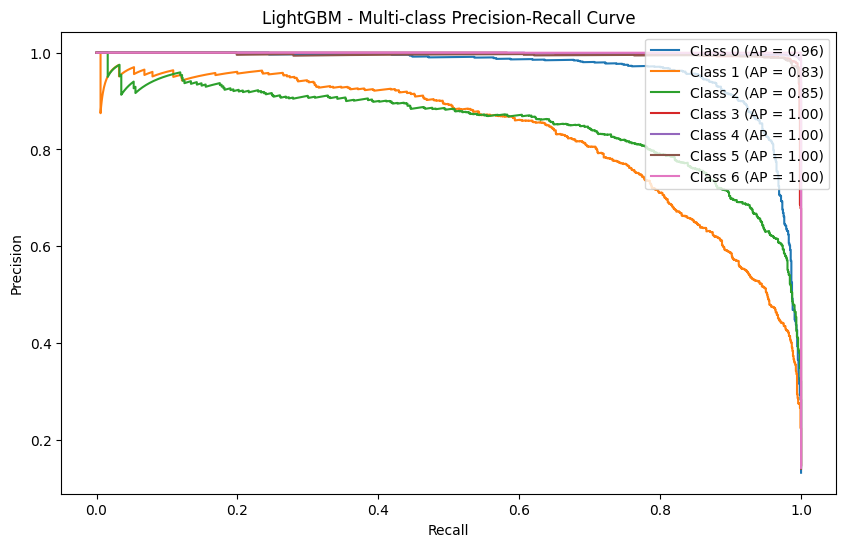

Confusion Matrix:
 [[ 986   38   20    4    5   38    0]
 [  41  842  269   26   24   14    5]
 [  46  158  985    1    2    2    0]
 [   1    3    0 1222    1    0    0]
 [   0    0    0    0 1210    0    0]
 [   0    3    0    2    0 1151    0]
 [   0    0    0    0    0    0 1174]]
Model: LightGBM Classifier
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.9150
Train Accuracy: 0.9886

Test Metrics for each class:
Class 0:
  Precision: 0.9181
  Recall: 0.9038
  F1 Score: 0.9109
  Accuracy: 0.9038
Class 1:
  Precision: 0.8065
  Recall: 0.6896
  F1 Score: 0.7435
  Accuracy: 0.6896
Class 2:
  Precision: 0.7732
  Recall: 0.8250
  F1 Score: 0.7982
  Accuracy: 0.8250
Class 3:
  Precision: 0.9737
  Recall: 0.9959
  F1 Score: 0.9847
  Accuracy: 0.9959
Class 4:
  Precision: 0.9742
  Recall: 1.0000
  F1 Score: 0.9869
  Accuracy: 1.0000
Class 5:
  Precision: 0.9552
  Recall: 0.9957
  F1 Score: 0.9750
  Accuracy: 0.9957
Class 6:
  Precision: 0.9958
  Recall: 1.0000
  F1 Score: 0.

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix, accuracy_score)
from sklearn.preprocessing import label_binarize
import numpy as np

# Train LightGBM model
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train_combined, y_train)

# Get probability estimates for ROC & Precision-Recall curves
y_pred_prob = lgbm.predict_proba(X_test_combined)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LightGBM - Multi-class Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Make predictions on test and train sets
y_test_pred = lgbm.predict(X_test_combined)
y_train_pred = lgbm.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the results for each class
print("Model: LightGBM Classifier")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score, and Accuracy
print("\nTest Metrics for each class:")
for i, class_label in enumerate(test_classification_report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")
        print(f"  Accuracy: {class_wise_accuracy[i]:.4f}")

print("\nTrain Metrics for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


#Naive Bayes

In [ ]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Before fitting the model, clip negative values to 0
X_train_combined_non_negative = np.clip(X_train_combined, 0, None)
X_test_combined_non_negative = np.clip(X_test_combined, 0, None)

# Initialize and train the Naive Bayes model using the modified data
nb_model = MultinomialNB()
nb_model.fit(X_train_combined_non_negative, y_train) # Use clipped data

# Make predictions using the clipped test data
y_test_pred = nb_model.predict(X_test_combined_non_negative)  # Use clipped data
y_train_pred = nb_model.predict(X_train_combined_non_negative) # Use clipped data

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate Precision (macro)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')

# Calculate Recall (macro)
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')

# Calculate F1 Score (macro)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

# Display the results
print("Model: Naive Bayes")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision_macro:.4f}")
print(f"Train Precision (macro): {train_precision_macro:.4f}")
print(f"Test Recall (macro): {test_recall_macro:.4f}")
print(f"Train Recall (macro): {train_recall_macro:.4f}")
print(f"Test F1 Score (macro): {test_f1_macro:.4f}")
print(f"Train F1 Score (macro): {train_f1_macro:.4f}")

# Classification Report for both Test and Train sets
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
print("\nClassification Report (Train Set):\n", classification_report(y_train, y_train_pred))


Model: Naive Bayes
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.5241
Train Accuracy: 0.5316
Test Precision (macro): 0.5852
Train Precision (macro): 0.6005
Test Recall (macro): 0.5290
Train Recall (macro): 0.5382
Test F1 Score (macro): 0.5247
Train F1 Score (macro): 0.5344

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.48      0.83      0.61      1091
           1       0.45      0.38      0.41      1221
           2       0.58      0.30      0.39      1194
           3       0.90      0.44      0.59      1227
           4       0.80      0.56      0.66      1210
           5       0.34      0.57      0.43      1156
           6       0.56      0.62      0.59      1174

    accuracy                           0.52      8273
   macro avg       0.59      0.53      0.52      8273
weighted avg       0.59      0.52      0.52      8273


Classification Report (Train Set):
               precision    recall  f1

In [ ]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Before fitting the model, clip negative values to 0
X_train_combined_non_negative = np.clip(X_train_combined, 0, None)
X_test_combined_non_negative = np.clip(X_test_combined, 0, None)

# Initialize and train the Naive Bayes model using the modified data
nb_model = MultinomialNB()
nb_model.fit(X_train_combined_non_negative, y_train) # Use clipped data

# Make predictions using the clipped test data
y_test_pred = nb_model.predict(X_test_combined_non_negative)  # Use clipped data
y_train_pred = nb_model.predict(X_train_combined_non_negative) # Use clipped data

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Display the results for each class
print("Model: Naive Bayes")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score
print("\nTest Precision, Recall, F1 Score for each class:")
for class_label in test_classification_report.keys():
    if class_label not in ('accuracy', 'macro avg', 'weighted avg'):  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")

print("\nTrain Precision, Recall, F1 Score for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ('accuracy', 'macro avg', 'weighted avg'):  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


Confusion Matrix:
 [[904  13  49   7   8  80  30]
 [202 468 133  11  42 239 126]
 [222 364 353   4  10 183  58]
 [248  39   9 544  42 264  81]
 [100  46   9   5 674 260 116]
 [ 82 110  38  33  56 662 175]
 [134   8  18   0  12 271 731]]
Model: Naive Bayes
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.5241
Train Accuracy: 0.5316

Test Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.4778
  Recall: 0.8286
  F1 Score: 0.6061
Class 1:
  Precision: 0.4466
  Recall: 0.3833
  F1 Score: 0.4125
Class 2:
  Precision: 0.5796
  Recall: 0.2956
  F1 Score: 0.3916
Class 3:
  Precision: 0.9007
  Recall: 0.4434
  F1 Score: 0.5942
Class 4:
  Precision: 0.7986
  Recall: 0.5570
  F1 Score: 0.6563
Class 5:
  Precision: 0.3379
  Recall: 0.5727
  F1 Score: 0.4250
Class 6:
  Precision: 0.5550
  Recall: 0.6227
  F1 Score: 0.5869

Train Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.4596
  Recall: 0.8263
  F1 Score: 0.5907
Class 1:
  Precision: 0.4920
 

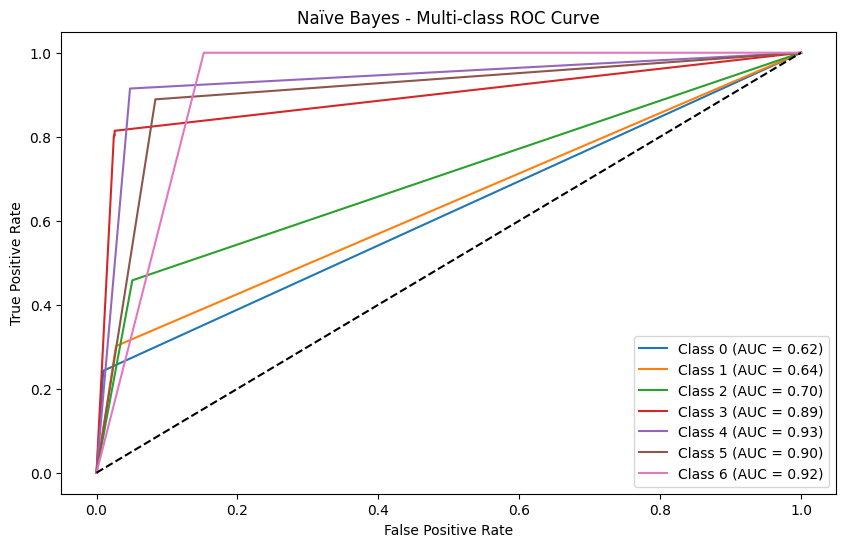

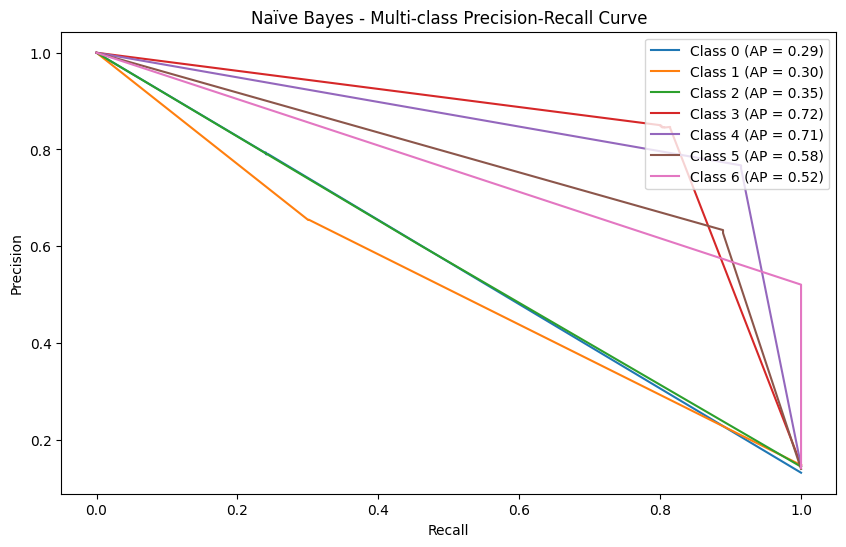

Confusion Matrix:
 [[ 261   67   68   62   85  178  370]
 [  43  367  292   66  113  145  195]
 [  25  117  547   45  102  124  234]
 [   0    6    0  982   34  100  105]
 [   0    4    0    0 1107   48   51]
 [   0    0    0    0    2 1028  126]
 [   0    0    0    0    0    0 1174]]
Model: Naïve Bayes Classifier
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.6607
Train Accuracy: 0.7763

Test Metrics for each class:
Class 0:
  Precision: 0.7933
  Recall: 0.2392
  F1 Score: 0.3676
  Accuracy: 0.2392
Class 1:
  Precision: 0.6542
  Recall: 0.3006
  F1 Score: 0.4119
  Accuracy: 0.3006
Class 2:
  Precision: 0.6031
  Recall: 0.4581
  F1 Score: 0.5207
  Accuracy: 0.4581
Class 3:
  Precision: 0.8502
  Recall: 0.8003
  F1 Score: 0.8245
  Accuracy: 0.8003
Class 4:
  Precision: 0.7672
  Recall: 0.9149
  F1 Score: 0.8345
  Accuracy: 0.9149
Class 5:
  Precision: 0.6334
  Recall: 0.8893
  F1 Score: 0.7398
  Accuracy: 0.8893
Class 6:
  Precision: 0.5206
  Recall: 1.0000
  F1 Score:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix, accuracy_score)
from sklearn.preprocessing import label_binarize
import numpy as np

# Train Naïve Bayes model
nb = GaussianNB()
nb.fit(X_train_combined, y_train)

# Get probability estimates for ROC & Precision-Recall curves
y_pred_prob = nb.predict_proba(X_test_combined)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naïve Bayes - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Naïve Bayes - Multi-class Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Make predictions on test and train sets
y_test_pred = nb.predict(X_test_combined)
y_train_pred = nb.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the results for each class
print("Model: Naïve Bayes Classifier")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score, and Accuracy
print("\nTest Metrics for each class:")
for i, class_label in enumerate(test_classification_report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")
        print(f"  Accuracy: {class_wise_accuracy[i]:.4f}")

print("\nTrain Metrics for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


#AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize and train the AdaBoost model
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
y_test_pred = ada_model.predict(X_test_combined)
y_train_pred = ada_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate Precision (macro)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')

# Calculate Recall (macro)
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')

# Calculate F1 Score (macro)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

# Display the results
print("Model: AdaBoost")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision_macro:.4f}")
print(f"Train Precision (macro): {train_precision_macro:.4f}")
print(f"Test Recall (macro): {test_recall_macro:.4f}")
print(f"Train Recall (macro): {train_recall_macro:.4f}")
print(f"Test F1 Score (macro): {test_f1_macro:.4f}")
print(f"Train F1 Score (macro): {train_f1_macro:.4f}")

# Classification Report for both Test and Train sets
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
print("\nClassification Report (Train Set):\n", classification_report(y_train, y_train_pred))


Model: AdaBoost
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.6555
Train Accuracy: 0.6476
Test Precision (macro): 0.6578
Train Precision (macro): 0.6517
Test Recall (macro): 0.6578
Train Recall (macro): 0.6519
Test F1 Score (macro): 0.6546
Train F1 Score (macro): 0.6480

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.62      0.85      0.72      1091
           1       0.53      0.48      0.50      1221
           2       0.61      0.55      0.58      1194
           3       0.71      0.70      0.70      1227
           4       0.81      0.75      0.78      1210
           5       0.55      0.56      0.56      1156
           6       0.78      0.72      0.75      1174

    accuracy                           0.66      8273
   macro avg       0.66      0.66      0.65      8273
weighted avg       0.66      0.66      0.65      8273


Classification Report (Train Set):
               precision    recall  f1-sc

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the AdaBoost model
#ada_model = AdaBoostClassifier(random_state=42)
#ada_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
#y_test_pred = ada_model.predict(X_test_combined)
#y_train_pred = ada_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Display the results for each class
print("Model: AdaBoost")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score
print("\nTest Precision, Recall, F1 Score for each class:")
for class_label in test_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")

print("\nTrain Precision, Recall, F1 Score for each class:")
for class_label in train_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


Confusion Matrix:
 [[925  12  42   7   8  87  10]
 [127 587 277  58  48  84  40]
 [167 304 655   8  14  29  17]
 [ 63  43   6 853  65 160  37]
 [ 54  71  29  37 912  64  43]
 [112  52  48 163  42 651  88]
 [ 42  45  20  79  34 114 840]]
Model: AdaBoost
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.6555
Train Accuracy: 0.6476

Test Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.6208
  Recall: 0.8478
  F1 Score: 0.7168
Class 1:
  Precision: 0.5269
  Recall: 0.4808
  F1 Score: 0.5028
Class 2:
  Precision: 0.6082
  Recall: 0.5486
  F1 Score: 0.5768
Class 3:
  Precision: 0.7079
  Recall: 0.6952
  F1 Score: 0.7015
Class 4:
  Precision: 0.8121
  Recall: 0.7537
  F1 Score: 0.7818
Class 5:
  Precision: 0.5475
  Recall: 0.5631
  F1 Score: 0.5552
Class 6:
  Precision: 0.7814
  Recall: 0.7155
  F1 Score: 0.7470

Train Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.6092
  Recall: 0.8568
  F1 Score: 0.7121
Class 1:
  Precision: 0.4989
  Re

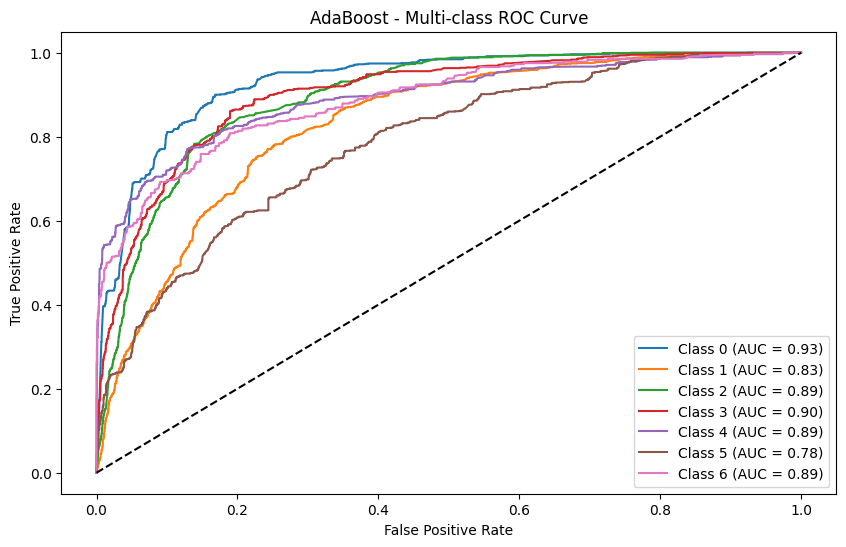

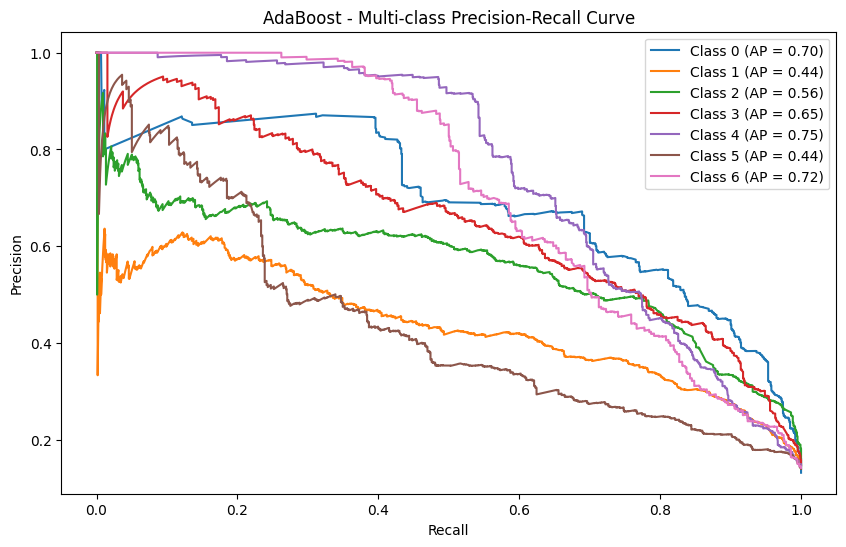

Confusion Matrix:
 [[898  19  26   7  14 117  10]
 [117 623 224  39  27 179  12]
 [190 363 513   0   7 116   5]
 [164  57   8 579  63 312  44]
 [ 50 104  19  26 792 177  42]
 [ 63  78  45 125  40 740  65]
 [ 73  62  28  31  48 234 698]]
Model: AdaBoost Classifier
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.5854
Train Accuracy: 0.5834

Test Metrics for each class:
Class 0:
  Precision: 0.5775
  Recall: 0.8231
  F1 Score: 0.6788
  Accuracy: 0.8231
Class 1:
  Precision: 0.4770
  Recall: 0.5102
  F1 Score: 0.4931
  Accuracy: 0.5102
Class 2:
  Precision: 0.5944
  Recall: 0.4296
  F1 Score: 0.4988
  Accuracy: 0.4296
Class 3:
  Precision: 0.7175
  Recall: 0.4719
  F1 Score: 0.5693
  Accuracy: 0.4719
Class 4:
  Precision: 0.7992
  Recall: 0.6545
  F1 Score: 0.7197
  Accuracy: 0.6545
Class 5:
  Precision: 0.3947
  Recall: 0.6401
  F1 Score: 0.4883
  Accuracy: 0.6401
Class 6:
  Precision: 0.7968
  Recall: 0.5945
  F1 Score: 0.6810
  Accuracy: 0.5945

Train Metrics for each c

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix, accuracy_score)
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Train AdaBoost model
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Correct syntax
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

adaboost.fit(X_train_combined, y_train)

# Get probability estimates for ROC & Precision-Recall curves
y_pred_prob = adaboost.predict_proba(X_test_combined)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AdaBoost - Multi-class Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Make predictions on test and train sets
y_test_pred = adaboost.predict(X_test_combined)
y_train_pred = adaboost.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the results for each class
print("Model: AdaBoost Classifier")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score, and Accuracy
print("\nTest Metrics for each class:")
for i, class_label in enumerate(test_classification_report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")
        print(f"  Accuracy: {class_wise_accuracy[i]:.4f}")

print("\nTrain Metrics for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


#XGBoost

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.2 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
y_test_pred = xgb_model.predict(X_test_combined)
y_train_pred = xgb_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate Precision (macro)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')

# Calculate Recall (macro)
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')

# Calculate F1 Score (macro)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

# Display the results
print("Model: XGBoost")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Precision (macro): {test_precision_macro:.4f}")
print(f"Train Precision (macro): {train_precision_macro:.4f}")
print(f"Test Recall (macro): {test_recall_macro:.4f}")
print(f"Train Recall (macro): {train_recall_macro:.4f}")
print(f"Test F1 Score (macro): {test_f1_macro:.4f}")
print(f"Train F1 Score (macro): {train_f1_macro:.4f}")

# Classification Report for both Test and Train sets
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))
print("\nClassification Report (Train Set):\n", classification_report(y_train, y_train_pred))


Model: XGBoost
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.9087
Train Accuracy: 0.9807
Test Precision (macro): 0.9066
Train Precision (macro): 0.9807
Test Recall (macro): 0.9095
Train Recall (macro): 0.9812
Test F1 Score (macro): 0.9072
Train F1 Score (macro): 0.9808

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1091
           1       0.79      0.68      0.73      1221
           2       0.77      0.80      0.78      1194
           3       0.97      0.99      0.98      1227
           4       0.97      1.00      0.98      1210
           5       0.95      0.99      0.97      1156
           6       1.00      1.00      1.00      1174

    accuracy                           0.91      8273
   macro avg       0.91      0.91      0.91      8273
weighted avg       0.91      0.91      0.91      8273


Classification Report (Train Set):
               precision    recall  f1-sco

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_combined, y_train)

# Make predictions on test and train sets
y_test_pred = xgb_model.predict(X_test_combined)
y_train_pred = xgb_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Display the results for each class
print("Model: XGBoost")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score
print("\nTest Precision, Recall, F1 Score for each class:")
for class_label in test_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")

print("\nTrain Precision, Recall, F1 Score for each class:")
for class_label in train_classification_report.keys():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


Confusion Matrix:
 [[ 988   32   20    7    8   35    1]
 [  46  827  271   25   28   21    3]
 [  66  174  950    1    1    2    0]
 [   0    4    0 1219    2    2    0]
 [   0    0    0    0 1210    0    0]
 [   0    4    0    2    0 1150    0]
 [   0    0    0    0    0    0 1174]]
Model: XGBoost
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.9087
Train Accuracy: 0.9807

Test Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.8982
  Recall: 0.9056
  F1 Score: 0.9019
Class 1:
  Precision: 0.7944
  Recall: 0.6773
  F1 Score: 0.7312
Class 2:
  Precision: 0.7655
  Recall: 0.7956
  F1 Score: 0.7803
Class 3:
  Precision: 0.9721
  Recall: 0.9935
  F1 Score: 0.9827
Class 4:
  Precision: 0.9688
  Recall: 1.0000
  F1 Score: 0.9841
Class 5:
  Precision: 0.9504
  Recall: 0.9948
  F1 Score: 0.9721
Class 6:
  Precision: 0.9966
  Recall: 1.0000
  F1 Score: 0.9983

Train Precision, Recall, F1 Score for each class:
Class 0:
  Precision: 0.9643
  Recall: 0.9957
  F1

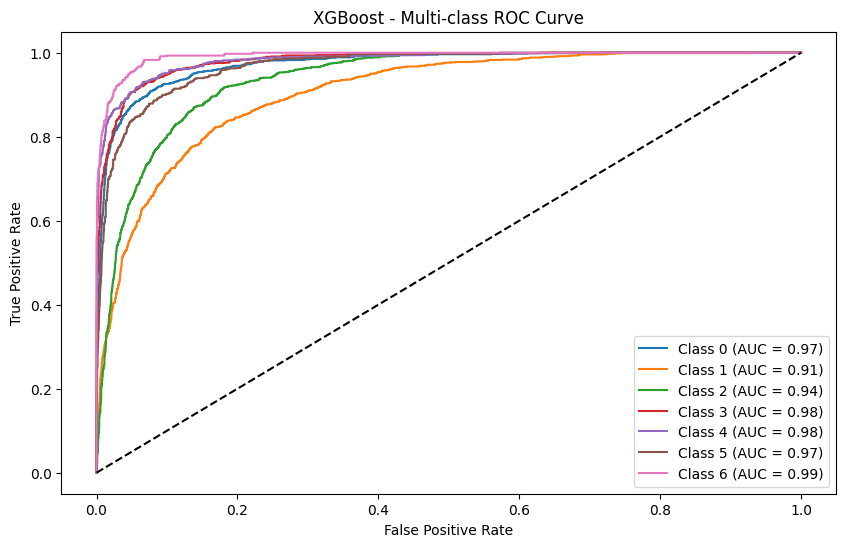

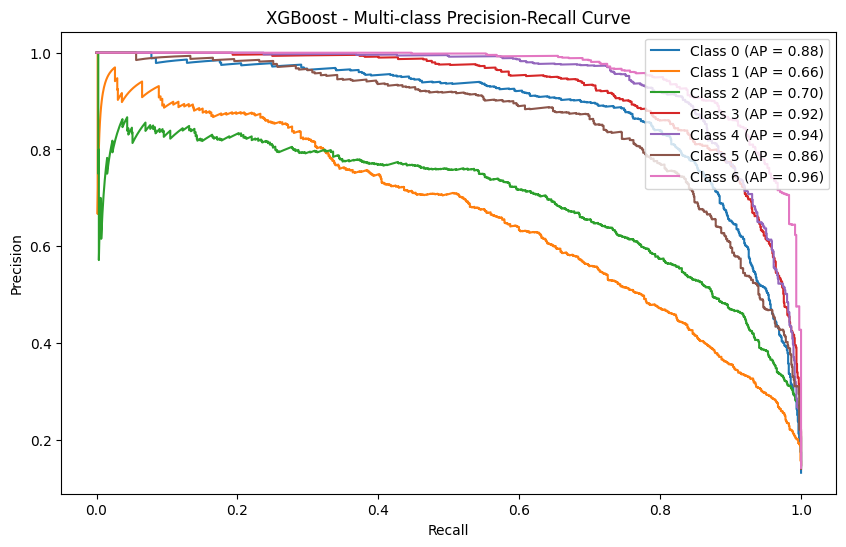

Confusion Matrix:
 [[ 953   29   22    5    2   66   14]
 [  67  692  318   49   28   48   19]
 [ 131  206  820    6    6   22    3]
 [  25   28   12 1039   16   78   29]
 [  27   55   20   31  981   62   34]
 [  23   35   39   96    9  925   29]
 [  31   32   21   17    0   45 1028]]
Model: XGBoost Classifier
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.7782
Train Accuracy: 0.7815

Test Metrics for each class:
Class 0:
  Precision: 0.7582
  Recall: 0.8735
  F1 Score: 0.8118
  Accuracy: 0.8735
Class 1:
  Precision: 0.6425
  Recall: 0.5667
  F1 Score: 0.6023
  Accuracy: 0.5667
Class 2:
  Precision: 0.6550
  Recall: 0.6868
  F1 Score: 0.6705
  Accuracy: 0.6868
Class 3:
  Precision: 0.8359
  Recall: 0.8468
  F1 Score: 0.8413
  Accuracy: 0.8468
Class 4:
  Precision: 0.9415
  Recall: 0.8107
  F1 Score: 0.8712
  Accuracy: 0.8107
Class 5:
  Precision: 0.7424
  Recall: 0.8002
  F1 Score: 0.7702
  Accuracy: 0.8002
Class 6:
  Precision: 0.8893
  Recall: 0.8756
  F1 Score: 0.8

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix, accuracy_score)
from sklearn.preprocessing import label_binarize
import numpy as np

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Multi-class classification
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train_combined, y_train)

# Get probability estimates for ROC & Precision-Recall curves
y_pred_prob = xgb_model.predict_proba(X_test_combined)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost - Multi-class Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Make predictions on test and train sets
y_test_pred = xgb_model.predict(X_test_combined)
y_train_pred = xgb_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the results for each class
print("Model: XGBoost Classifier")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score, and Accuracy
print("\nTest Metrics for each class:")
for i, class_label in enumerate(test_classification_report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")
        print(f"  Accuracy: {class_wise_accuracy[i]:.4f}")

print("\nTrain Metrics for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")


#Proposed Model

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# Define base models
base_models = [
    ('lgbm', lgb.LGBMClassifier(n_estimators=100, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Define XGBoost as final estimator
final_estimator = XGBClassifier(
    reg_alpha=0.5,  # Equivalent to alpha
    reg_lambda=1.0,  # Equivalent to lambda_
    learning_rate=0.05,
    n_estimators=450,
    random_state=42
)

# Stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator)

# Train the stacking model
stacking_model.fit(X_train_combined, y_train)

# Make predictions
y_pred = stacking_model.predict(X_test_combined)

# Print accuracy
print(f"Ensemble Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.607653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417549
[LightGBM] [Info] Number of data points in the train set: 33091, number of used features: 5230
[LightGBM] [Info] Start training from score -2.074708
[LightGBM] [Info] Start training from score -1.917400
[LightGBM] [Info] Start training from score -1.911660
[LightGBM] [Info] Start training from score -1.935030
[LightGBM] [Info] Start training from score -1.908802
[LightGBM] [Info] Start training from score -1.940275
[LightGBM] [Info] Start training from score -1.943224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.497981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393896
[LightGBM] [Info] Number of data points in the train set: 26472, number of used features: 4735
[LightGBM] [Info] Start training fro

In [ ]:
print(f"Ensemble Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.4f}%")

Ensemble Model Accuracy: 93.2068%


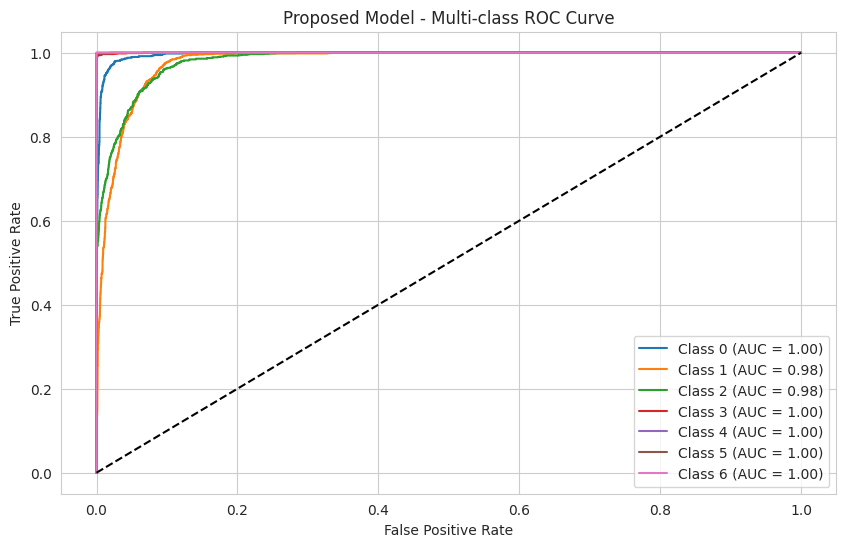

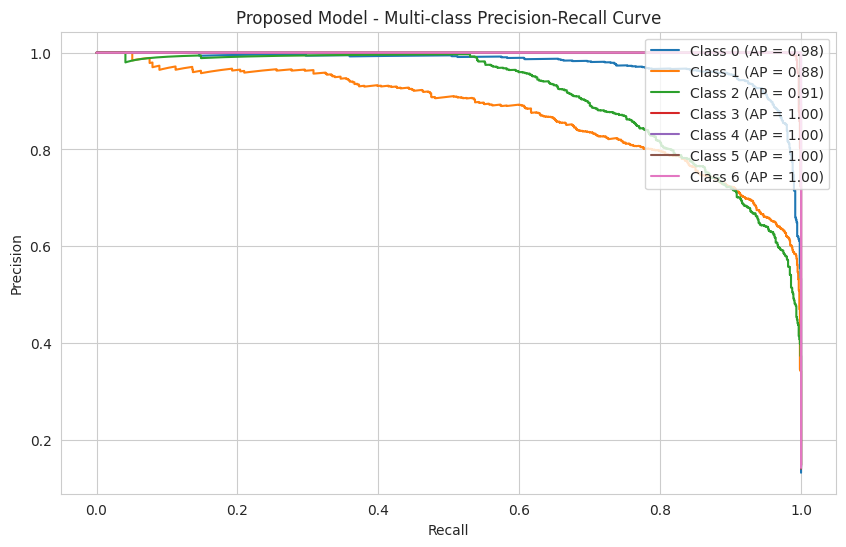

Confusion Matrix:
 [[1036   36   16    2    0    1    0]
 [  53  966  195    5    2    0    0]
 [  40  197  957    0    0    0    0]
 [   2   11    0 1214    0    0    0]
 [   0    0    0    0 1210    0    0]
 [   0    2    0    0    0 1154    0]
 [   0    0    0    0    0    0 1174]]
Model: stacking Classifier
Disorder: (Specify disorder name if applicable)
Test Accuracy: 0.9321
Train Accuracy: 0.9984

Test Metrics for each class:
Class 0:
  Precision: 0.9160
  Recall: 0.9496
  F1 Score: 0.9325
  Accuracy: 0.9496
Class 1:
  Precision: 0.7970
  Recall: 0.7912
  F1 Score: 0.7941
  Accuracy: 0.7912
Class 2:
  Precision: 0.8193
  Recall: 0.8015
  F1 Score: 0.8103
  Accuracy: 0.8015
Class 3:
  Precision: 0.9943
  Recall: 0.9894
  F1 Score: 0.9918
  Accuracy: 0.9894
Class 4:
  Precision: 0.9983
  Recall: 1.0000
  F1 Score: 0.9992
  Accuracy: 1.0000
Class 5:
  Precision: 0.9991
  Recall: 0.9983
  F1 Score: 0.9987
  Accuracy: 0.9983
Class 6:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.

In [ ]:

# Get probability estimates for ROC & Precision-Recall curves
y_pred_prob = stacking_model.predict_proba(X_test_combined)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Proposed Model - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Proposed Model - Multi-class Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Make predictions on test and train sets
y_test_pred = stacking_model.predict(X_test_combined)
y_train_pred = stacking_model.predict(X_train_combined)

# Calculate Test and Train Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print confusion matrix to get class-specific details
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for each class
test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

# Calculate class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the results for each class
print("Model: stacking Classifier")
print("Disorder: (Specify disorder name if applicable)")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# For each class, print Precision, Recall, F1 Score, and Accuracy
print("\nTest Metrics for each class:")
for i, class_label in enumerate(test_classification_report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {test_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {test_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {test_classification_report[class_label]['f1-score']:.4f}")
        print(f"  Accuracy: {class_wise_accuracy[i]:.4f}")

print("\nTrain Metrics for each class:")
for class_label in train_classification_report.keys():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore aggregated metrics
        print(f"Class {class_label}:")
        print(f"  Precision: {train_classification_report[class_label]['precision']:.4f}")
        print(f"  Recall: {train_classification_report[class_label]['recall']:.4f}")
        print(f"  F1 Score: {train_classification_report[class_label]['f1-score']:.4f}")
